# Outline

This project contains two parts:Timeseries and FNN<p>
**For comparison between different methods and models, please refer to the last part of this file.**

In [1]:
library(lubridate)
library(quantmod)
library(dplyr)
library(pROC)              
# library(MASS)
library(MLeval)
library(forecast)
library(Ecdat)
library(rugarch)
library(tseries)
library(Hmisc)
library(ggplot2) 
library(repr)
data(Mishkin, package = "Ecdat")

Warning message:
"package 'lubridate' was built under R version 4.0.5"

Attaching package: 'lubridate'


The following objects are masked from 'package:base':

    date, intersect, setdiff, union


Warning message:
"package 'quantmod' was built under R version 4.0.5"
Loading required package: xts

Warning message:
"package 'xts' was built under R version 4.0.5"
Loading required package: zoo

Warning message:
"package 'zoo' was built under R version 4.0.5"

Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Loading required package: TTR

Warning message:
"package 'TTR' was built under R version 4.0.5"
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Warning message:
"package 'dplyr' was built under R version 4.0.5"

Attaching package: 'dplyr'


The following objects are masked from 'package:xts':

    first, last


The following objects are masked from 'package:stats':

    fi

## Data Processing & Testing
The data was downloaded from Yahoo Finance. It contains the price data of this stock from Jan 2, 2015 to Dec 31, 2020. The symbol is **AMZN**.<p>
1) First, calculate the log return of the stock. The log return is defined by:
$r_{t}=\log \left(P_{t}\right)-\log \left(P_{t-1}\right)$ <p>
&nbsp;&nbsp;&nbsp;&nbsp;In our project, we only onsider about adjusted price.<p>
2) Conduct describe analysis for adjusted close price log return, the result as following:

|       |Min   |1st Qu.|Median|Mean  |3rd Qu.|Max  |
|-----    |-----  |-----  |----- |----- |-----  |----- |
| Adj Close|286.9  |727.8  |1194.7|1376.0|1829.0 |3531.4|
| Log Rtn  |-0.0825|-0.0071|0.0014|0.0016|0.0107 |0.1322|


3) Then plot the time series of Adj.Close and logR, and conduct ADF test to see if they are stationary.<p>
&nbsp;&nbsp;&nbsp;&nbsp;The result of KPSS tests shows that Adj.close is **stationary**. Though ADF and PP do not reject the NULL hypothesis, we still determine that the sequence is stationary, since:<p>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;According to Katircioglu, Feridun and Kilinc (2014) and Jafari, Othman and Nor (2012) PP and ADF unit root tests which were designed on the basis of the null hypothesis that a series is stationary have a low power of rejecting the null. It is suggested that KPSS unit root test eliminates a possible low power against stationary unit root that occurs in the ADF and PP ( Katircioglu , Feridun , & Kilinc , 2014; Jafari , Othman, & Nor, 2012). Therefore, if there is a situation in which you obtained a mixed and inconsistent results we should  rely on the KPSS unit root test results as it yields more robust results.<p>
4) Conduct Ljung-Box test to check the independency.<p>
&nbsp;&nbsp;&nbsp;&nbsp;Here we define the lag by:&nbsp;&nbsp; $lag = log(obs)$, where obs is the number of observations inside the train set.<p>
&nbsp;&nbsp;&nbsp;&nbsp;The test result shows that&nbsp;&nbsp; $ p value < 0.05 $, thus logR is **NOT a white noise process**. <p>

In [2]:
# read data, set time format, calculate log return

data = read.csv("AMZN.csv")
attach(data)
n=dim(data)[1]
logR=diff(log(Adj.Close))
data$logR = c(0,diff(log(data$Adj.Close)))
length(Adj.Close)
data[1259:1510,]
data

[1] 1510

,Date,Open,High,Low,Close,Adj.Close,Volume,logR
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
1259,2020-01-02,1875.00,1898.01,1864.15,1898.01,1898.01,4029000,0.026788603
1260,2020-01-03,1864.50,1886.20,1864.50,1874.97,1874.97,3764400,-0.012213330
1261,2020-01-06,1860.00,1903.69,1860.00,1902.88,1902.88,4061800,0.014775887
1262,2020-01-07,1904.50,1913.89,1892.04,1906.86,1906.86,4044900,0.002089372
1263,2020-01-08,1898.04,1911.00,1886.44,1891.97,1891.97,3508000,-0.007839303
1264,2020-01-09,1909.89,1917.82,1895.80,1901.05,1901.05,3167300,0.004787792
1265,2020-01-10,1905.37,1906.94,1880.00,1883.16,1883.16,2853700,-0.009455156
1266,2020-01-13,1891.31,1898.00,1880.80,1891.30,1891.30,2780800,0.004313214
1267,2020-01-14,1885.88,1887.11,1858.55,1869.44,1869.44,3440900,-0.011625560


Date,Open,High,Low,Close,Adj.Close,Volume,logR
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
2015-01-02,312.58,314.75,306.96,308.52,308.52,2783200,0.000000000
2015-01-05,307.01,308.38,300.85,302.19,302.19,2774200,-0.020730670
2015-01-06,302.24,303.00,292.38,295.29,295.29,3519000,-0.023098010
2015-01-07,297.50,301.28,295.33,298.42,298.42,2640300,0.010543979
2015-01-08,300.32,303.14,296.11,300.46,300.46,3088400,0.006812670
2015-01-09,301.48,302.87,296.68,296.93,296.93,2592400,-0.011818206
2015-01-12,297.56,298.51,289.28,291.41,291.41,3421400,-0.018765173
2015-01-13,297.48,301.50,293.23,294.74,294.74,4136400,0.011362354
2015-01-14,291.93,295.91,286.50,293.27,293.27,5538700,-0.004999929


In [3]:
# description

summary(data)

     Date                Open             High             Low        
 Length:1510        Min.   : 286.3   Min.   : 290.8   Min.   : 285.2  
 Class :character   1st Qu.: 726.6   1st Qu.: 730.4   1st Qu.: 720.8  
 Mode  :character   Median :1198.7   Median :1205.4   Median :1188.4  
                    Mean   :1376.4   Mean   :1390.7   Mean   :1359.9  
                    3rd Qu.:1828.7   3rd Qu.:1844.9   3rd Qu.:1811.8  
                    Max.   :3547.0   Max.   :3552.2   Max.   :3486.7  
     Close          Adj.Close          Volume              logR          
 Min.   : 286.9   Min.   : 286.9   Min.   :  881300   Min.   :-0.082535  
 1st Qu.: 727.8   1st Qu.: 727.8   1st Qu.: 2855425   1st Qu.:-0.007083  
 Median :1194.7   Median :1194.7   Median : 3735200   Median : 0.001366  
 Mean   :1376.0   Mean   :1376.0   Mean   : 4315149   Mean   : 0.001567  
 3rd Qu.:1829.0   3rd Qu.:1829.0   3rd Qu.: 5101675   3rd Qu.: 0.010726  
 Max.   :3531.4   Max.   :3531.4   Max.   :23856100   Max. 

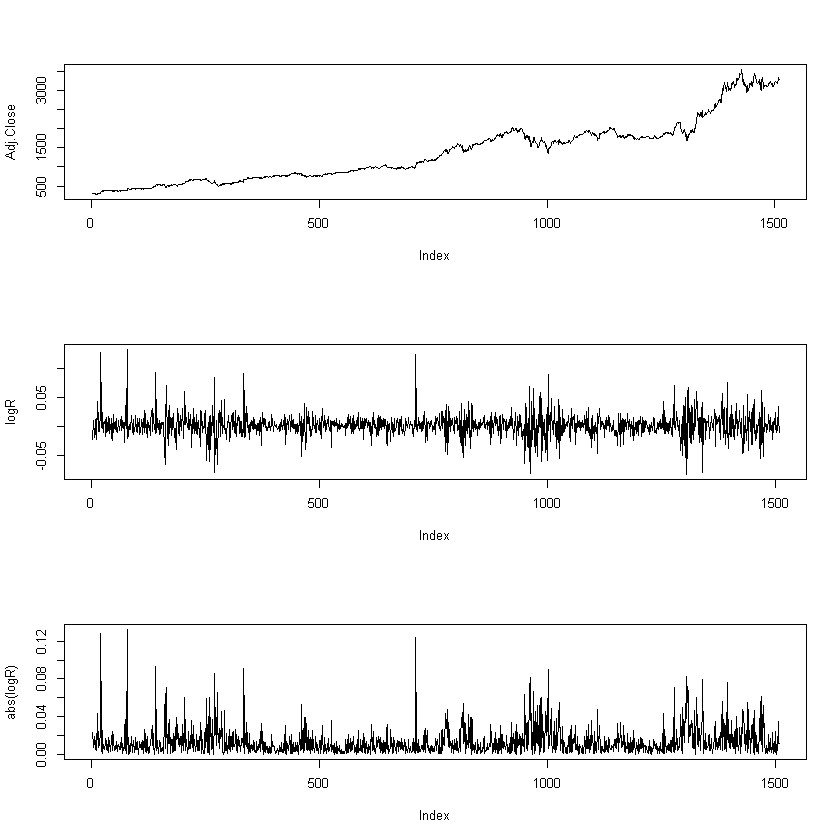

In [4]:
# plot the time series of Adj.Close and logR to see if they are stationary

par(mfrow=c(3,1))
plot(Adj.Close, type="l")
plot(logR, type="l")
plot(abs(logR), type="l")

In [5]:
# conduct ADF test, PP test and KPSS test to see if they are stationary

adf.test(Adj.Close)
pp.test(Adj.Close)
kpss.test(Adj.Close)


	Augmented Dickey-Fuller Test

data:  Adj.Close
Dickey-Fuller = -1.4436, Lag order = 11, p-value = 0.8139
alternative hypothesis: stationary



	Phillips-Perron Unit Root Test

data:  Adj.Close
Dickey-Fuller Z(alpha) = -7.3295, Truncation lag parameter = 7, p-value
= 0.7009
alternative hypothesis: stationary


Warning message in kpss.test(Adj.Close):
"p-value smaller than printed p-value"



	KPSS Test for Level Stationarity

data:  Adj.Close
KPSS Level = 16.75, Truncation lag parameter = 7, p-value = 0.01



	Box-Ljung test

data:  Adj.Close
X-squared = 10339, df = 7.1373, p-value < 2.2e-16


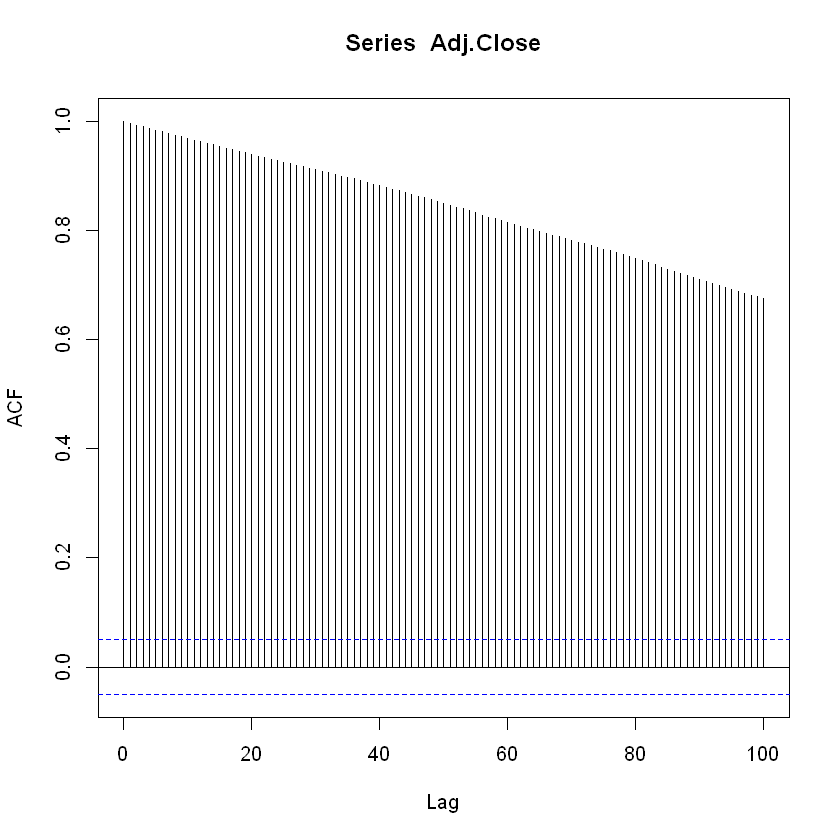

In [6]:
# Sample autocorrelations for logR

acf(Adj.Close,lag.max=100) 

# Ljung-Box test. We define lag by the log number of obs.

Box.test(Adj.Close, lag = log(1258), type = "Ljung-Box")

## Time Series Model
1) We use the first five years of data for training your model and the last year's data for testing.Divide the data into two parts.<p>
2) Use ARIMA model to fit the adjusted close. Use the auto.arima function to find the optimal order of the ARMA part.<p>
&nbsp;&nbsp;&nbsp;&nbsp;The output shows that the optimal model is ARIMA(0,1,1).<p>

3) Conduct the Ljung-box test for squared residuals to test the independencies.<p>
&nbsp;&nbsp;&nbsp;&nbsp;The output is&nbsp;$ pvalue = 2.2e-16<0.05$, indicating that the residuals are not white noise, and the model is not suitable.<p>
&nbsp;&nbsp;&nbsp;&nbsp;Therefore, we are going to use ARMA/GARCH model to fit the sequence.<p>
4) Use ARMA/GARCH to fit the sequence. <p>
&nbsp;&nbsp;&nbsp;&nbsp;We first use **ARMA/GARCH** with normal distribution.<p>
&nbsp;&nbsp;&nbsp;&nbsp;The result shows that the model is combined with **GARCH(1,1) and mean model ARIMA(0,1,1)**.<p>
&nbsp;&nbsp;&nbsp;&nbsp;The log Likelihood is 3946.556. The weighted Ljung-Box test indicates that the residuals are independent. On QQ-plot we can see that there are lots of observations deviatited from the theoretical model. We conduct Shapiro-Wilk test to test the normality, and the result rejected the normality hypothesis.<p>
5) Then we fit again using **ARMA/GARCH with t distribution**. We namely use ARMA(0,1) and ARMA(1,1) as mean model.<p>
&nbsp;&nbsp;&nbsp;&nbsp;The weighted Ljung-Box test indicates that the residuals for two mean models are all independent. On QQ-plot we can see that the fitting performance is better when using ARMA(1,1).<p>



In [3]:
trainSet = Adj.Close[1:1258]
testSet = Adj.Close[1259:1510]

In [4]:
# Find the orders for the ARMA part
# Then replace outliers and do it again

fit=auto.arima(Adj.Close, lambda = "auto")
summary(fit)

Series: Adj.Close 
ARIMA(0,1,1) with drift 
Box Cox transformation: lambda= 0.1665666 

Coefficients:
          ma1   drift
      -0.0375  0.0050
s.e.   0.0258  0.0016

sigma^2 estimated as 0.004063:  log likelihood=2013.9
AIC=-4021.79   AICc=-4021.78   BIC=-4005.84

Training set error measures:
                      ME     RMSE      MAE         MPE     MAPE      MASE
Training set -0.03301217 32.61911 19.04207 -0.01672962 1.310141 0.9933521
                    ACF1
Training set -0.02764515


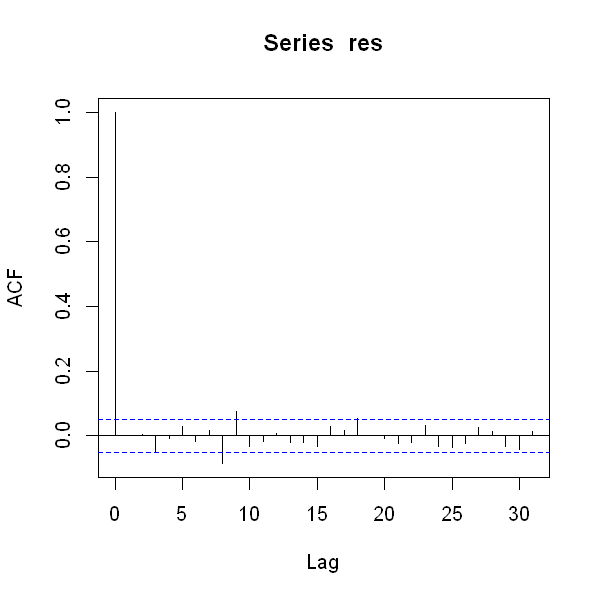


	Box-Ljung test

data:  res^2
X-squared = 182.79, df = 7.1373, p-value < 2.2e-16


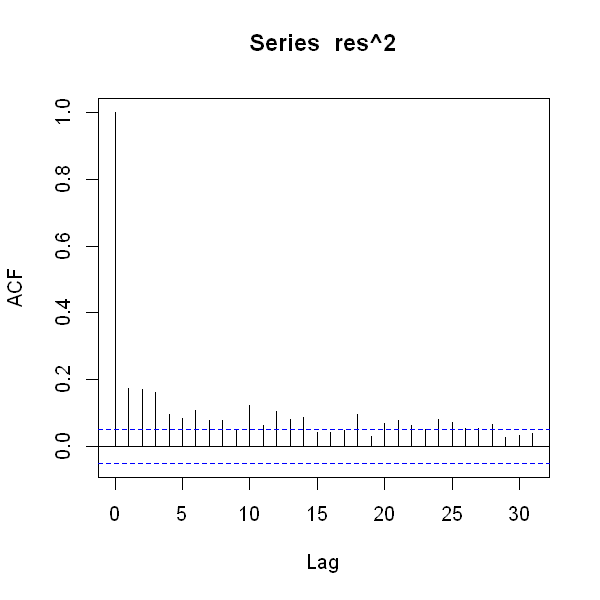

In [6]:
# Check the autocorrelation for the residuals

options(repr.plot.width=5, repr.plot.height=5)
res=fit$resid
acf(res)
acf(res^2)
Box.test(res^2, lag = log(1258), type = "Ljung-Box")

In [7]:
# fit GARCH models

arma.garch.norm = ugarchspec(mean.model=list(armaOrder=c(0,1)),variance.model=list(garchOrder=c(1,1))) 
fit.garch.norm = ugarchfit(data=data.frame(trainSet), spec=arma.garch.norm)
show(fit.garch.norm)


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(0,0,1)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu     766.56274    2.457593 311.9161  0.00000
ma1      0.93242    0.011261  82.8039  0.00000
omega    7.80024    4.970956   1.5692  0.11661
alpha1   0.26502    0.045176   5.8663  0.00000
beta1    0.73398    0.044245  16.5889  0.00000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu     766.56274    5.239592 146.3020  0.00000
ma1      0.93242    0.021579  43.2100  0.00000
omega    7.80024    4.972018   1.5688  0.11669
alpha1   0.26502    0.033018   8.0263  0.00000
beta1    0.73398    0.034434  21.3160  0.00000

LogLikelihood : -8169.363 

Information Criteria
------------------------------------
               


please wait...calculating quantiles...


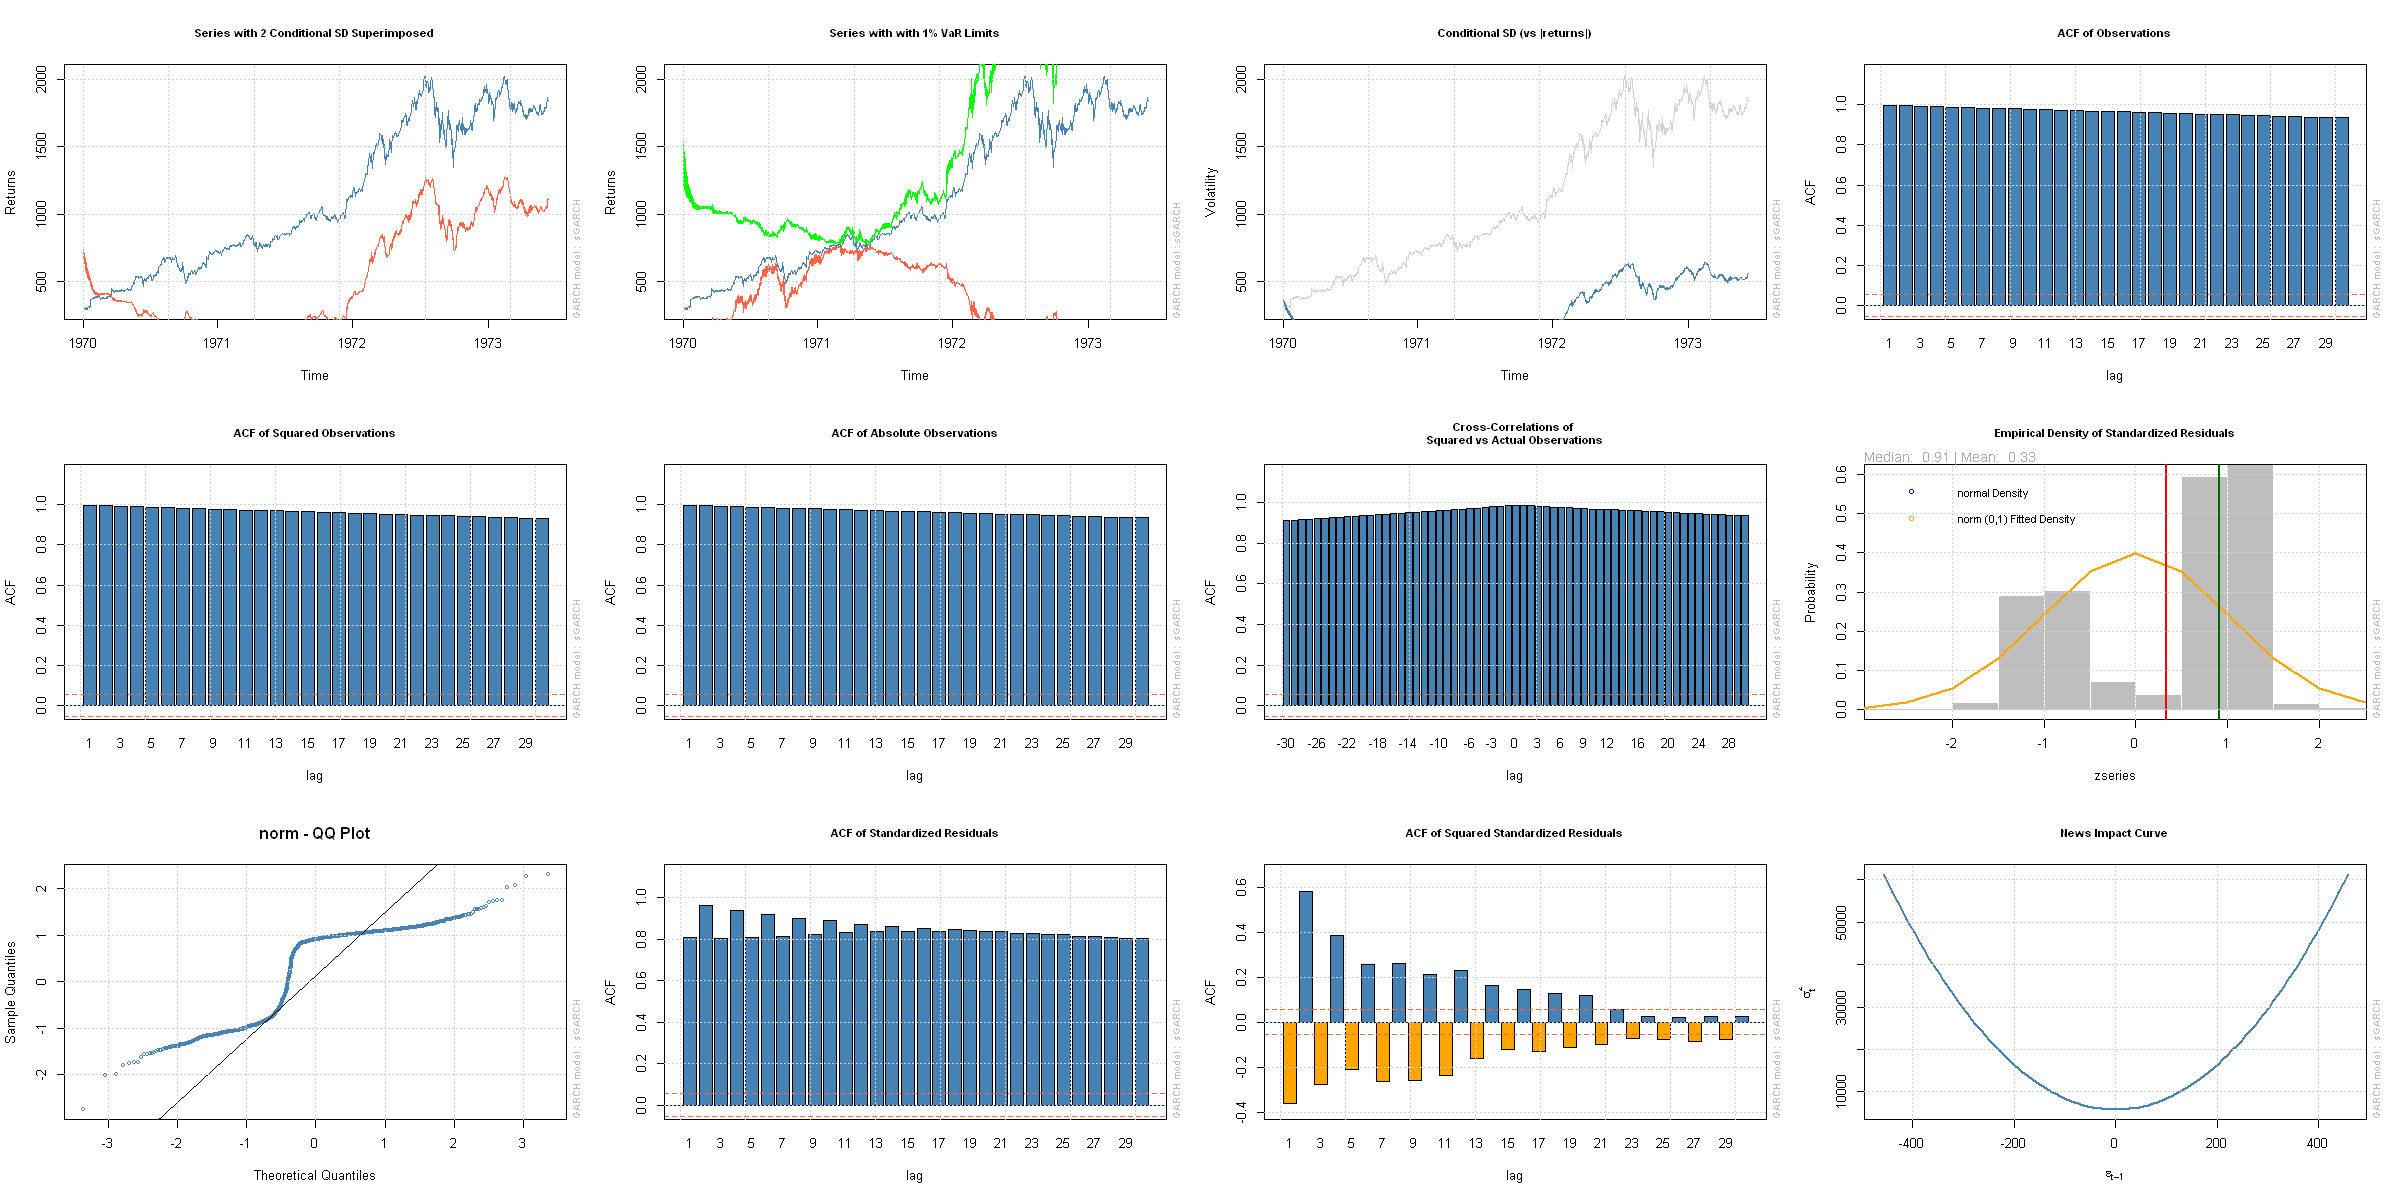

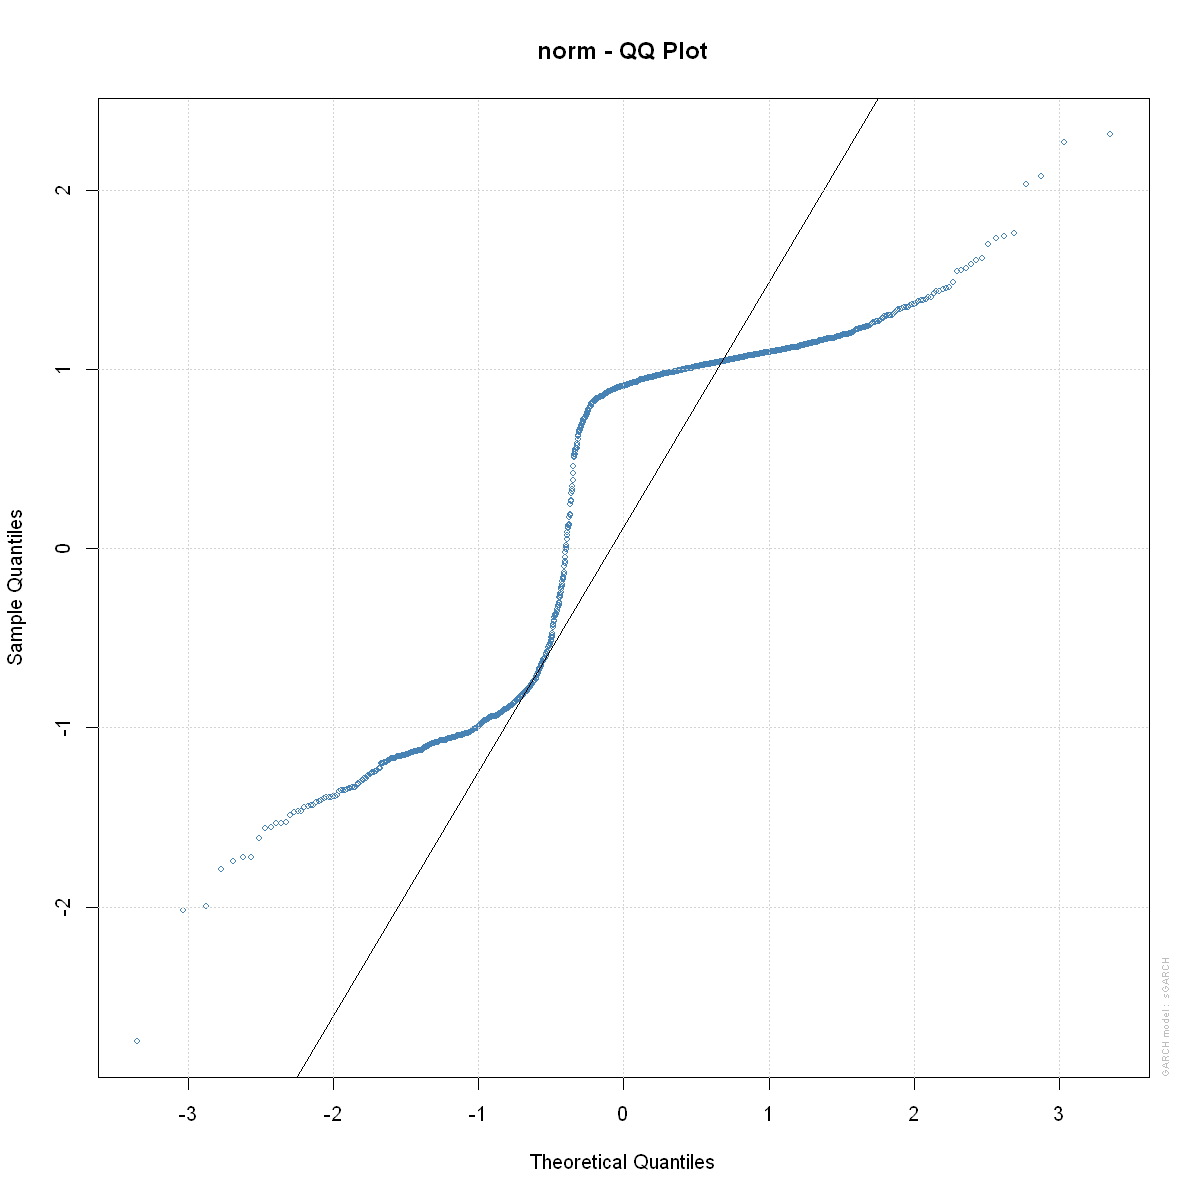

In [8]:
options(repr.plot.width=20, repr.plot.height=10) # set height and width of graph 

plot(fit.garch.norm, which="all")   # Show all 12 plots together.
# plot(fit.garch.norm, which="ask")  # Ask which plot to show. You only make one plot at a time. This function is not availabe in Jupyter, but you can use it in R console. 

options(repr.plot.width=10, repr.plot.height=10) # set height and width of graph 
plot(fit.garch.norm, which=9)         # Show plot no.1.

In [9]:
e = residuals(fit.garch.norm, standardize=TRUE)
# Test normality
shapiro.test(as.numeric(e))
jarque.bera.test(as.numeric(e)) # load package tseries


	Shapiro-Wilk normality test

data:  as.numeric(e)
W = 0.80269, p-value < 2.2e-16



	Jarque Bera Test

data:  as.numeric(e)
X-squared = 167.95, df = 2, p-value < 2.2e-16


In [10]:
# Fit the standardized residuals under the Gaussian white noise assumption using t distribution. 
library(MASS)
fitdistr(e,"t")

Warning message:
"package 'MASS' was built under R version 4.0.5"

Attaching package: 'MASS'


The following object is masked from 'package:Ecdat':

    SP500


The following object is masked from 'package:dplyr':

    select


Warning message in log(s):
"产生了NaNs"
Warning message in log(s):
"产生了NaNs"
Warning message in log(s):
"产生了NaNs"
Warning message in log(s):
"产生了NaNs"
Warning message in log(s):
"产生了NaNs"
Warning message in log(s):
"产生了NaNs"
Warning message in log(s):
"产生了NaNs"
Warning message in log(s):
"产生了NaNs"
Warning message in log(s):
"产生了NaNs"
Warning message in log(s):
"产生了NaNs"
Warning message in log(s):
"产生了NaNs"
Warning message in log(s):
"产生了NaNs"
Warning message in log(s):
"产生了NaNs"
Warning message in log(s):
"产生了NaNs"
Warning message in log(s):
"产生了NaNs"
Warning message in log(s):
"产生了NaNs"
Warning message in log(s):
"产生了NaNs"
Warning message in log(s):
"产生了NaNs"
Warning message in log(s):
"产生了NaNs"
Warning message in log(s):
"产生了NaNs"
Warning message in log(s):
"产生了N

ERROR: Error in fitdistr(e, "t"): optimization failed


In [4]:
# Refit the GARCH model using t distribution

arma.garch.t = ugarchspec(mean.model=list(armaOrder=c(0,1)),
                             variance.model=list(garchOrder=c(1,1)),
                          distribution.model = "std")        # std means student t distribution
fit.garch.t = ugarchfit(data=data.frame(trainSet), spec=arma.garch.t)
show(fit.garch.t)


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(0,0,1)
Distribution	: std 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu     766.53588    2.473012 309.9604 0.000000
ma1      0.93256    0.011326  82.3410 0.000000
omega    7.94454    5.146099   1.5438 0.122637
alpha1   0.26466    0.044502   5.9472 0.000000
beta1    0.73434    0.044364  16.5527 0.000000
shape   99.99975   29.314980   3.4112 0.000647

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu     766.53588    5.307095 144.4361  0.00000
ma1      0.93256    0.021982  42.4232  0.00000
omega    7.94454    5.217800   1.5226  0.12786
alpha1   0.26466    0.032951   8.0321  0.00000
beta1    0.73434    0.035019  20.9694  0.00000
shape   99.99975    1.296634  77.1225  0.00000

LogLikel

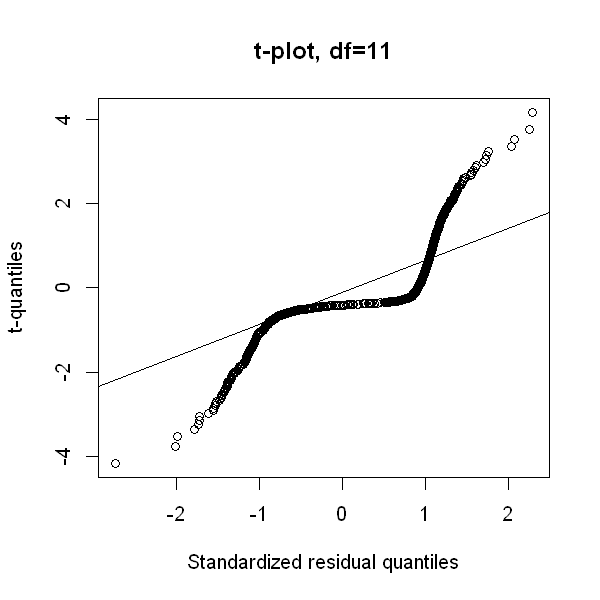

In [5]:
options(repr.plot.width=5, repr.plot.height=5) # set height and width of graph 

# qqplot for t distribution with a given degrees of freedom
e = residuals(fit.garch.t, standardize=TRUE)
n = length(e)
grid = (1:n)/(n+1)
qqplot(sort(as.numeric(e)), qt(grid,df=11),
       main="t-plot, df=11",xlab= "Standardized residual quantiles",
       ylab="t-quantiles")
abline(   lm(   qt(c(.25,.75),df=11)~quantile(e,c(.25,.75))   )   )

In [6]:
arma.garch.t1 = ugarchspec(mean.model=list(armaOrder=c(1,1)),
                             variance.model=list(garchOrder=c(1,1)),
                          distribution.model = "std")        # std means student t distribution
fit.garch.t1 = ugarchfit(data=data.frame(trainSet), spec=arma.garch.t1)
show(fit.garch.t1)


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(1,0,1)
Distribution	: std 

Optimal Parameters
------------------------------------
         Estimate  Std. Error   t value Pr(>|t|)
mu     308.748056   11.369312   27.1563 0.000000
ar1      1.000000    0.000563 1777.7306 0.000000
ma1      0.033532    0.028934    1.1589 0.246485
omega    4.580157    2.130995    2.1493 0.031610
alpha1   0.155664    0.032575    4.7786 0.000002
beta1    0.843336    0.033611   25.0914 0.000000
shape    4.191430    0.437827    9.5733 0.000000

Robust Standard Errors:
         Estimate  Std. Error   t value Pr(>|t|)
mu     308.748056    0.674988  457.4130 0.000000
ar1      1.000000    0.000684 1462.5604 0.000000
ma1      0.033532    0.029761    1.1267 0.259862
omega    4.580157    3.235133    1.4158 0.156847
alpha1   0.155664    0.046731 

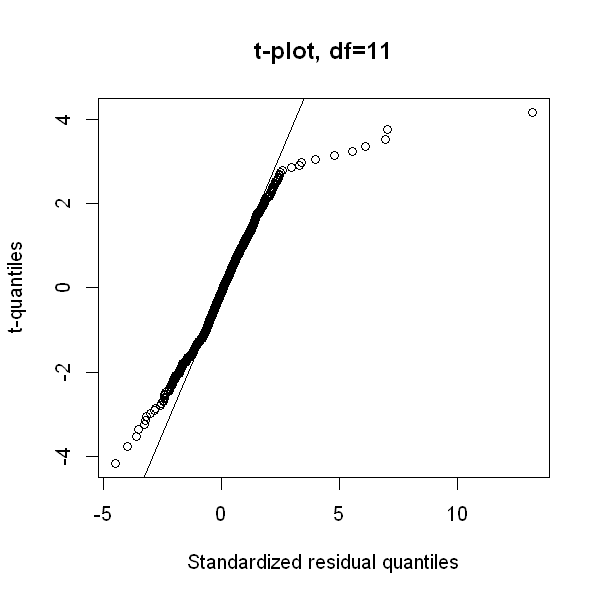

In [7]:
options(repr.plot.width=5, repr.plot.height=5) # set height and width of graph 

# qqplot for t distribution with a given degrees of freedom
e = residuals(fit.garch.t1, standardize=TRUE)
n = length(e)
grid = (1:n)/(n+1)
qqplot(sort(as.numeric(e)), qt(grid,df=11),
       main="t-plot, df=11",xlab= "Standardized residual quantiles",
       ylab="t-quantiles")
abline(   lm(   qt(c(.25,.75),df=11)~quantile(e,c(.25,.75))   )   )

## Prediction - TimeSeries
We are going to use ugarchpredict function to predict the log return in 2020. We can see that the ARMA(0,1)/GARCH(1,1) model does not provide a good fit.<p>
To have another try in case there are influences of abnormal data, we try ARMA(1,1)/GARCH(1,1). This time the model fits well.<p>
In FNN task, we used standardized adjusted close price.Therefore, we do that again inorder to compare the MSE.<p>
**MSE for the ARMA(0,1)/GARCH(1,1) model is 1.7105**<p>
**MSE for the ARMA(1,1)/GARCH(1,1) model is 0.0065**

In [22]:
pred=ugarchforecast(fit.garch.t, n.ahead=10)
mean=fitted(pred)
std=sigma(pred)
print(pred)


*------------------------------------*
*       GARCH Model Forecast         *
*------------------------------------*
Model: sGARCH
Horizon: 10
Roll Steps: 0
Out of Sample: 0

0-roll forecast [T0=1973-06-12 08:00:00]:
     Series Sigma
T+1  1257.4 549.2
T+2   766.5 548.9
T+3   766.5 548.6
T+4   766.5 548.4
T+5   766.5 548.1
T+6   766.5 547.8
T+7   766.5 547.6
T+8   766.5 547.3
T+9   766.5 547.0
T+10  766.5 546.8




In [23]:
length(Adj.Close)
length(testSet)

[1] 1510

[1] 252

In [24]:
arma.garch.t = ugarchspec(mean.model=list(armaOrder=c(0,1)), variance.model=list(garchOrder=c(1,1)), distribution.model = "std")       
fit.garch.t2 = ugarchfit(data=data.frame(Adj.Close), spec=arma.garch.t, out.sample=252)

pred_roll = ugarchforecast(fit.garch.t2, data=data.frame(Adj.Close), n.ahead=1, n.roll=251)
# n.ahead is the number of days on which you want to make predictions, i.e., the forecast horizon. 
# n.roll is the number of rolling forecasts to create beyond the first forecast. 

fitted(pred_roll)
sigma(pred_roll)

,1973-06-12 08:00:00,1973-06-13 08:00:00,1973-06-14 08:00:00,1973-06-15 08:00:00,1973-06-16 08:00:00,1973-06-17 08:00:00,1973-06-18 08:00:00,1973-06-19 08:00:00,1973-06-20 08:00:00,1973-06-21 08:00:00,...,1974-02-09 08:00:00,1974-02-10 08:00:00,1974-02-11 08:00:00,1974-02-12 08:00:00,1974-02-13 08:00:00,1974-02-14 08:00:00,1974-02-15 08:00:00,1974-02-16 08:00:00,1974-02-17 08:00:00,1974-02-18 08:00:00
T+1,1257.45,1363.898,1243.142,1381.782,1256.203,1359.427,1271.632,1336.823,1283.62,1312.849,...,1910.404,2007.361,1912.392,1968.848,1920.424,1965.899,1903.674,1949.971,2010.562,1989.532


,1973-06-12 08:00:00,1973-06-13 08:00:00,1973-06-14 08:00:00,1973-06-15 08:00:00,1973-06-16 08:00:00,1973-06-17 08:00:00,1973-06-18 08:00:00,1973-06-19 08:00:00,1973-06-20 08:00:00,1973-06-21 08:00:00,...,1974-02-09 08:00:00,1974-02-10 08:00:00,1974-02-11 08:00:00,1974-02-12 08:00:00,1974-02-13 08:00:00,1974-02-14 08:00:00,1974-02-15 08:00:00,1974-02-16 08:00:00,1974-02-17 08:00:00,1974-02-18 08:00:00
T+1,549.1826,574.5268,558.1462,586.4892,570.5847,588.2689,575.9975,585.3342,577.038,579.0947,...,1228.892,1256.001,1248.21,1258.588,1252.369,1260.764,1249.309,1253.936,1274.999,1284.113


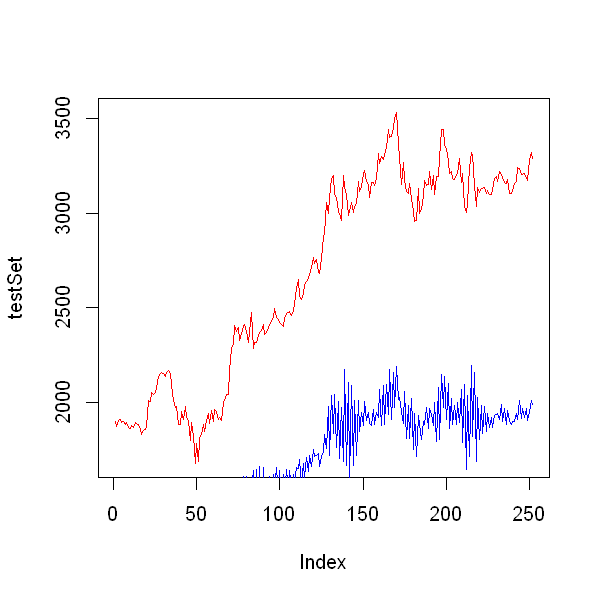

In [33]:
pred = as.numeric(fitted(pred_roll))
plot(testSet,type='l',col="red") 
lines(pred,type='l',col="blue")

In [41]:
arma.garch.t1 = ugarchspec(mean.model=list(armaOrder=c(1,1)), variance.model=list(garchOrder=c(1,1)), distribution.model = "std")       
fit.garch.t3 = ugarchfit(data=data.frame(Adj.Close), spec=arma.garch.t1, out.sample=252)
pred_roll = ugarchforecast(fit.garch.t3, data=data.frame(Adj.Close), n.ahead=1, n.roll=251)

fitted(pred_roll)
sigma(pred_roll)

,1973-06-12 08:00:00,1973-06-13 08:00:00,1973-06-14 08:00:00,1973-06-15 08:00:00,1973-06-16 08:00:00,1973-06-17 08:00:00,1973-06-18 08:00:00,1973-06-19 08:00:00,1973-06-20 08:00:00,1973-06-21 08:00:00,...,1974-02-09 08:00:00,1974-02-10 08:00:00,1974-02-11 08:00:00,1974-02-12 08:00:00,1974-02-13 08:00:00,1974-02-14 08:00:00,1974-02-15 08:00:00,1974-02-16 08:00:00,1974-02-17 08:00:00,1974-02-18 08:00:00
T+1,1847.897,1899.69,1874.141,1903.843,1906.961,1891.467,1901.371,1882.549,1891.593,1868.697,...,3165.348,3243.495,3235.831,3200.503,3206.37,3206.525,3184.557,3172.292,3287.704,3323.149


,1973-06-12 08:00:00,1973-06-13 08:00:00,1973-06-14 08:00:00,1973-06-15 08:00:00,1973-06-16 08:00:00,1973-06-17 08:00:00,1973-06-18 08:00:00,1973-06-19 08:00:00,1973-06-20 08:00:00,1973-06-21 08:00:00,...,1974-02-09 08:00:00,1974-02-10 08:00:00,1974-02-11 08:00:00,1974-02-12 08:00:00,1974-02-13 08:00:00,1974-02-14 08:00:00,1974-02-15 08:00:00,1974-02-16 08:00:00,1974-02-17 08:00:00,1974-02-18 08:00:00
T+1,27.25103,31.96522,31.00651,30.72354,28.32052,26.75744,24.95337,24.1107,22.51119,22.54636,...,34.62465,43.65305,40.25158,39.40575,36.31995,33.42246,31.8898,29.73448,51.87789,49.57175


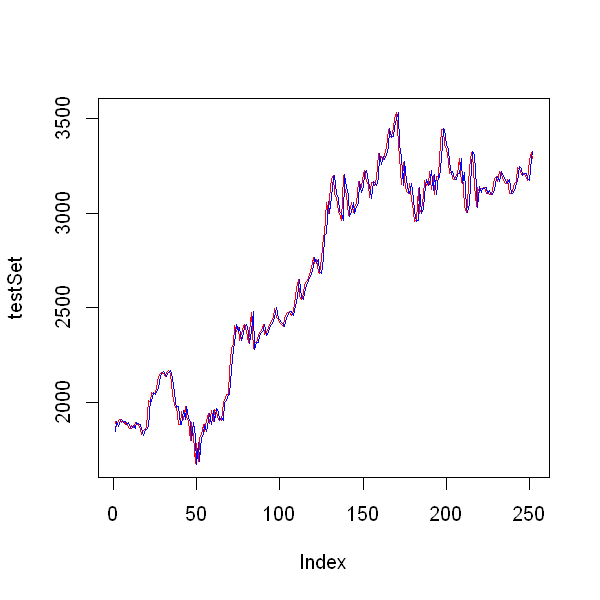

In [42]:
pred1 = as.numeric(fitted(pred_roll))
plot(testSet,type='l',col="red") 
lines(pred1,type='l',col="blue")

In [46]:
MSE = mean((testSet - pred) ^ 2)
MSE

[1] 1069655

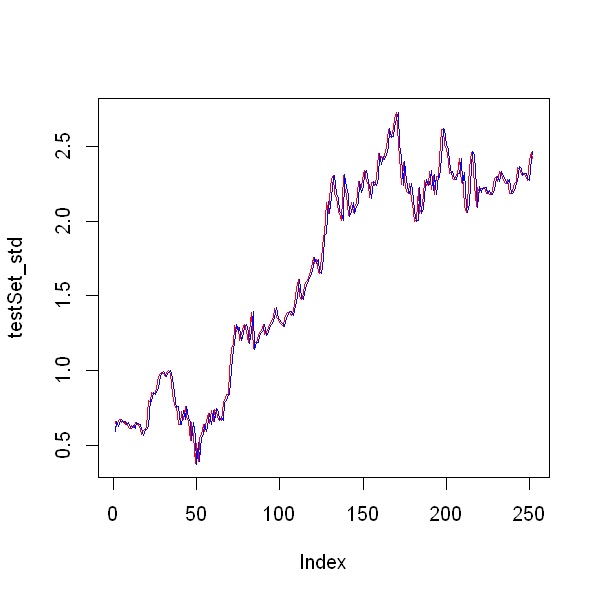

[1] 0.006503974

[1] 1.710546

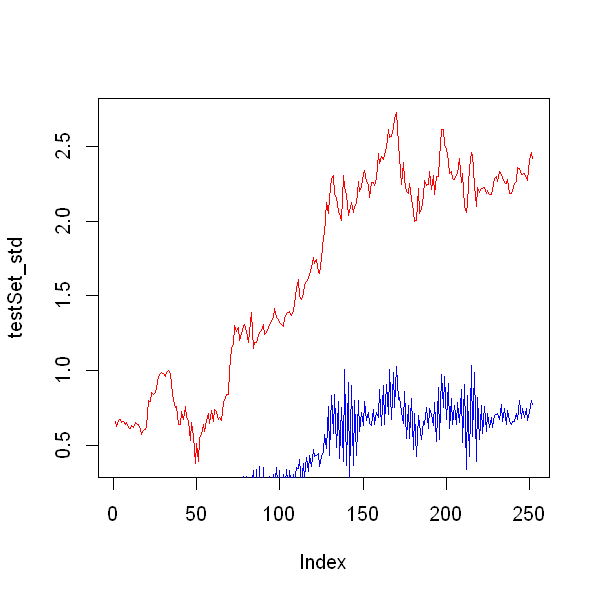

In [69]:
Adj.Close_std = (Adj.Close - mean(Adj.Close)) / sd(Adj.Close)
testSet_std = Adj.Close_std[1259:1510]
arma.garch.t1 = ugarchspec(mean.model=list(armaOrder=c(1,1)), variance.model=list(garchOrder=c(1,1)), distribution.model = "std")       
fit.garch.t3_std = ugarchfit(data=data.frame(Adj.Close_std), spec=arma.garch.t1, out.sample=252)
pred_roll_std = ugarchforecast(fit.garch.t3_std, data=data.frame(Adj.Close_std), n.ahead=1, n.roll=251)
fit.garch.t2 = ugarchfit(data=data.frame(Adj.Close_std), spec=arma.garch.t, out.sample=252)
pred_roll_std_1 = ugarchforecast(fit.garch.t2, data=data.frame(Adj.Close), n.ahead=1, n.roll=251)

pred1_std = as.numeric(fitted(pred_roll_std))
pred1_std_1 = as.numeric(fitted(pred_roll_std_1))

plot(testSet_std,type='l',col="red") 
lines(pred1_std,type='l',col="blue")
plot(testSet_std,type='l',col="red") 
lines(pred1_std_1,type='l',col="blue")

MSE_std = mean((testSet_std - pred1_std) ^ 2)
MSE_std_1 = mean((testSet_std - pred1_std_1) ^ 2)
MSE_std
MSE_std_1

## FNN Part
Please use python as kernel below

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.utils.data as Data
import torch.optim as optim
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')

In [2]:
df = pd.read_csv('C:/Users/ch/Desktop/cuhk/FTEC5580/project2/AMZN.csv')
df.shape

(1510, 7)

## Data Processing
The data was downloaded from Yahoo Finance. It contains the price data of this stock from Jan 2, 2015 to Dec 31, 2020. The symbol is **AMZN**.<p>
First, we are going to conduct some basic analysis on the data.<p>
Then standardize the price &nbsp; $p$  &nbsp;using: &nbsp;&nbsp;  $ p = (p - \mu) / \sigma $ <p>
Next we convert price data to arrays.

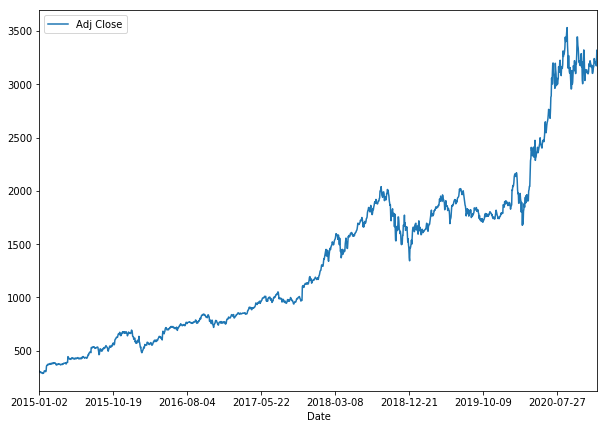

In [3]:
# plot adjusted close price with time

pricePath = np.array(df['Adj Close'])
df.plot(x="Date", y="Adj Close", figsize=(10, 7))

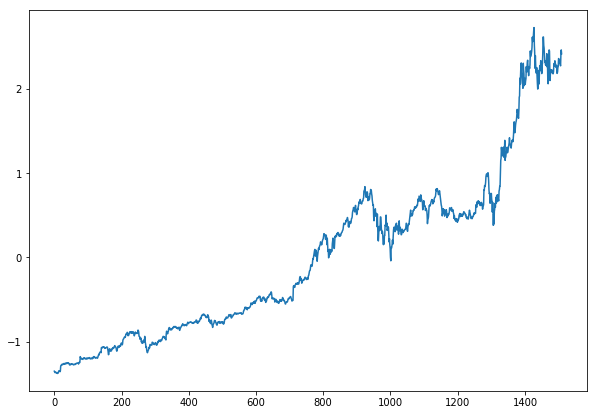

In [4]:
# standardize the price using: p = (p - mean(p)) / sigma
# new data array follows N(0,1)

pricePathStd = (pricePath - np.mean(pricePath)) / np.std(pricePath)
fig, ax = plt.subplots(figsize=(10, 7))
plt.plot(pricePathStd)

## Train & Test Set
We use the first five years of data for training your model and the last year's data for testing.

In [5]:
lag = 10

data = np.concatenate([pricePathStd[i: i+lag+1].reshape(1, -1)
                       for i in range(len(pricePathStd)-lag)], 0)
data.shape

(1500, 11)

In [6]:
# divide for different data sets

trainData = torch.from_numpy(data[0:1258]).float()
testData = torch.from_numpy(data[1258:]).float()

# set up Pytorch datasets & dataloaders

trainset = Data.TensorDataset(trainData[:, 0:-1], trainData[:, -1:])
testset = Data.TensorDataset(testData[:, 0:-1], testData[:, -1:])
trainloader = Data.DataLoader(trainset, batch_size=256, shuffle=True, num_workers=0)
testloader = Data.DataLoader(testset, batch_size=32, shuffle=True, num_workers=0)

criterion = torch.nn.MSELoss()

## Models
We are going to build two models: 
a Feedforward Neural Network (FNN), 
and 
a Logistic Regression (LR) model.


In [7]:
class FNN_net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden1, n_hidden2, n_output):
        super(FNN_net, self).__init__()  # inherit methods from torch.nn.Module

        self.hidden1 = torch.nn.Linear(n_feature, n_hidden1)  # h1 layer
        self.hidden2 = torch.nn.Linear(n_hidden1, n_hidden2)  # h2 layer
        self.output = torch.nn.Linear(n_hidden2, n_output)  # output layer
        self.n_feature = n_feature

    def forward(self, x):
        x = torch.relu_(self.hidden1(x))
        x = torch.relu_(self.hidden2(x))
        x = self.output(x)
        return x
    
class Logistic(torch.nn.Module):
    def __init__(self, n_feature):
        super(Logistic, self).__init__()
        self.output = torch.nn.Linear(n_feature, 1)

    def forward(self, x):
        x = torch.sigmoid_(self.output(x))
        return x

In [8]:
def test(model, dataloader):
    with torch.no_grad():
        running_loss = 0.0
        batch_num = 0
        for i, data in enumerate(dataloader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            outputs = model(inputs)  # forward propagation, get outputs
            loss = criterion(outputs, labels)  # get loss

            # record loss and other statistics
            running_loss += inputs.shape[0] * loss.item()
            batch_num += inputs.shape[0]
    return (running_loss / batch_num)

In [9]:
def train(model, num_epoch, dataloader):
    # SGD with momentum:
    # optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
    # Adam:
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    loss_train_list = []  # record training loss
    for epoch in range(num_epoch):  # loop over the dataset multiple times
        running_loss = 0.0
        batch_num = 0
        for i, data in enumerate(dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            # print(inputs.shape, labels.shape)
            # zero the parameter gradients
            optimizer.zero_grad()

            outputs = model(inputs)  # forward propagation, get outputs
            # print(outputs.squeeze())
            # print(labels.shape, outputs.shape)
            loss = criterion(outputs, labels)  # get loss
            loss.backward()  # back propagation, get gradients of loss
            optimizer.step()  # optimize one step

            # record loss and other statistics
            running_loss += inputs.shape[0] * loss.item()
            batch_num += inputs.shape[0]
        loss_train = running_loss / batch_num
        
        loss_train_list.append(loss_train)
    print('Finished Training')
    return loss_train_list

## Analysis
Here we are going to conduct training and the analysis. <p><p>
The MSE here is defined by: <p>
$ MSE=\frac{1}{n} \sum_{i=1}^{m} w_{i}\left(y_{i}-\hat{y}_{i}\right)^{2} $ <p><p><p>
**The Prediction MSE is illustrated by the following table:**


|  Model | Train loss | Test Loss   |
|---------|-------------|------------|
|  FNN   |   0.00091  |  0.01192  |
|   LR   |   0.45705  |  0.90747  |

In [11]:
fnn = FNN_net(10, 30, 30, 1)
lr = Logistic(10)
loss_fnn = train(fnn, 500, trainloader)
loss_lr = train(lr, 500, trainloader)

Finished Training
Finished Training


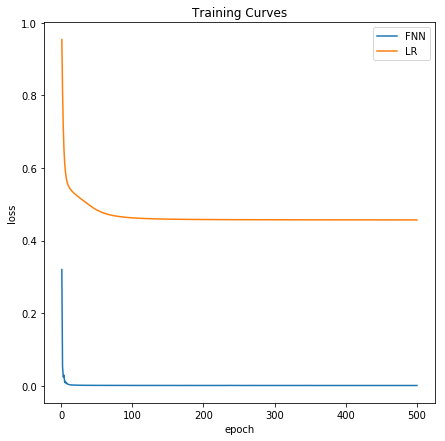

In [12]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(range(1, 1+len(loss_fnn)), loss_fnn, label="FNN")
ax.plot(range(1, 1+len(loss_lr)), loss_lr, label="LR")
ax.set_title("Training Curves")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.legend()

      *** Model MSE ***        

  Model | Train loss | Test Loss 
----------------------------------
   FNN  |   0.00074  |  0.00744
    LR  |   0.45687  |  0.90696


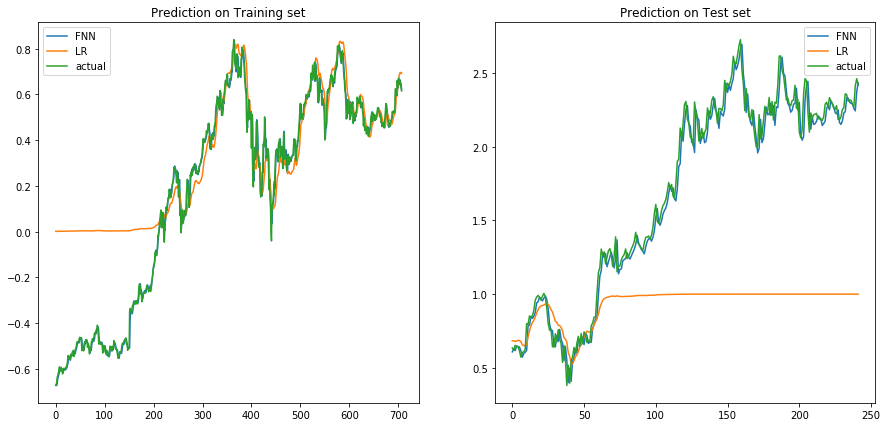

In [13]:
# Here we have a look at the prediction performance in a specific range

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
ax1.set_title("Prediction on Training set")
ax2.set_title("Prediction on Test set")
modelname = ["FNN", "LR"]

print("      *** Model MSE ***        ")
print("")
print("  Model | Train loss | Test Loss ")
print("----------------------------------")

for i,j in enumerate([fnn, lr]):
    ax1.plot(j(trainData[550:, :-1])
             [:, ].squeeze().data.numpy(), label=modelname[i])
    ax2.plot(j(testData[:, :-1])
             [:, 0].squeeze().data.numpy(), label=modelname[i])
    print("%6s  |  %8.5f  | %8.5f" % (modelname[i], test(j, trainloader), test(j, testloader)))

ax1.plot(trainData[550:, -1], label="actual")
ax2.plot(testData[:, -1], label="actual")

ax1.legend()
ax2.legend()

      *** Model MSE ***        

  Model | Train loss | Test Loss 
----------------------------------
   FNN  |   0.00074  |  0.00744
    LR  |   0.45687  |  0.90696


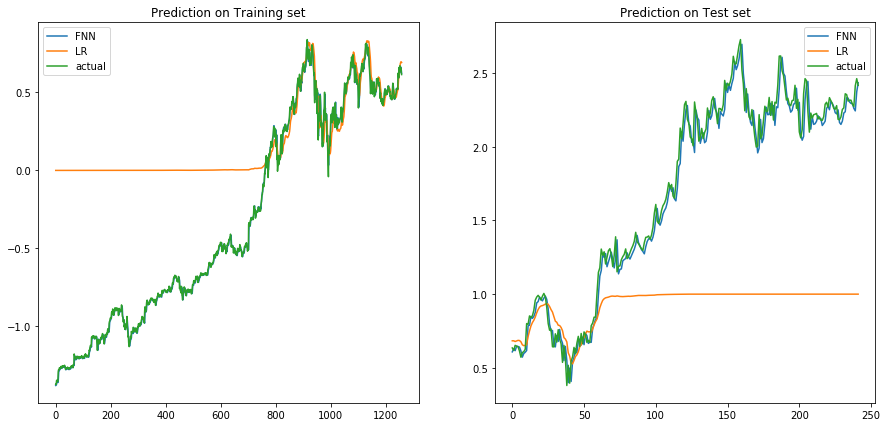

In [14]:
# Here we have a look at the prediction performance for the entire price path

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
ax1.set_title("Prediction on Training set")
ax2.set_title("Prediction on Test set")
modelname = ["FNN", "LR"]

print("      *** Model MSE ***        ")
print("")
print("  Model | Train loss | Test Loss ")
print("----------------------------------")

for i,j in enumerate([fnn, lr]):
    ax1.plot(j(trainData[:, :-1])
             [:, ].squeeze().data.numpy(), label=modelname[i])
    ax2.plot(j(testData[:, :-1])
             [:, 0].squeeze().data.numpy(), label=modelname[i])
    print("%6s  |  %8.5f  | %8.5f" % (modelname[i], test(j, trainloader), test(j, testloader)))

ax1.plot(trainData[:, -1], label="actual")
ax2.plot(testData[:, -1], label="actual")

ax1.legend()
ax2.legend()

## Conclusion

We have analyzed different methods and models to predict adjusted close price for AMZN in 2020. This test MSE for each are demonstrated below:

|Model          |Test MSE|
|:--------------------:|:----:|
|FNN            |0.0119|
|LR             |0.9075|
|ARMA(0,1)/GARCH(1,1)|1.7105|
|ARMA(1,1)/GARCH(1,1)|0.0065|

Therefore, in this case, ARMA(1,1)/GARCH(1,1) is the best model.